# Connecting structures together using Projection Detection

This example shows how to connect neurons in different structures together and is useful when you do not have the long range axons available. It can also be used within a volume, but note that this will then be in addition to what synapses touch detection provides (so useful when no axon is available).

* Define two volumes, ```VolumeA``` and ```VolumeB``` (far apart).
* Fill the volumes with ```dSPN``` and ```iSPN``` neurons respectively.
* Define the connection rule between the two neuron types.
* Create connections

## Define volumes

Here we use ```create_cube_mesh``` to create two cubical volumes with sides 300 micrometer that are 10 mm apart.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from snudda.place import create_cube_mesh

network_path = os.path.join("networks", "connect_structures_network_projection_detection")
mesh_file_a = os.path.join(network_path, "mesh", "volume_A.obj")
mesh_file_b = os.path.join(network_path, "mesh", "volume_B.obj")

create_cube_mesh(mesh_file_a, [5e-3,0,0], 300e-6, "Volume A - connect structures example")
create_cube_mesh(mesh_file_b, [-5e-3,0,0], 300e-6, "Volume B - connect structures example")

## Defining network, including projection

Normally neurons are connected using touch detection, but here we show how to connect neurons in separate volumes together. This can be used to create topographic maps between structures. To define a projection map (here [```data/ExampleProjectionDetection.json```](data/ExampleProjectionDetection.json)) we define a set of source points, and their corresponding target points. Intermediate points will be interpolated. Note that points outside the convex hull of the source points will have no projection defined.

```
{
    "ExampleProjection" : {
	"source" : [[4850, -150, -150],
                    [4850, -150, 150],
                    [4850, 150, -150],
                    [4850, 150, 150],
                    [5150, -150, -150],
                    [5150, -150, 150],
                    [5150, 150, -150],
                    [5150, 150, 150]],
	
	"destination" : [[-5150, -150, -150],
                         [-5150, -150, 150],
                         [-5150, 150, -150],
                         [-5150, 150, 150],
                         [-4850, -150, -150],
                         [-4850, -150, 150],
                         [-4850, 150, -150],
                         [-4850, 150, 150]],
	"radius" : 30e-6,
	"numPoints" : 10000,
	"rotation" : [[1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1],
		      [1, 0, 0, 0, 1, 0, 0, 0, 1]]
    }
    
}
```

Here a neuron at ```[4850, -150, -150]``` will project to a neuron at ```[-5150, -150, -150]```. 

The size of the projection zone is defined by the ```radius``` parameter, which is either a single value, or a vector corresponding to rx, ry, rz. E.g. ```[30e-6, 30e-6, 90e-6]```. Within the projection zone ```numPoints``` axon voxels are placed. 

The projection zone can be rotated according to the ```rotation``` (optional) parameter, which provides a rotation vector (9x1 corresponding to the 3x3 rotation matrix) for each destination point. This rotation is only relevant if radius specifies an ellipsoid. 

We define the structures (```define_structure```) using the mesh files created above, and add the neurons to the two volumes (```add_neurons```).

We use ```add_neuron_target``` but add also the ```projection_file``` as argument.

In [3]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="VolumeA", struct_mesh=mesh_file_a, d_min=15e-6, mesh_bin_width=50e-6)
si.define_structure(struct_name="VolumeB", struct_mesh=mesh_file_b, d_min=15e-6, mesh_bin_width=50e-6)

si.add_neurons(name="dSPN", num_neurons=20, volume_id="VolumeA",
               neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
si.add_neurons(name="iSPN", num_neurons=20, volume_id="VolumeB",
               neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

# Normally we would use add_neuron_target to connect the neurons in the same volume together, 
# but this time we want to use neuron_projection instead.

proj_file = os.path.join("data", "ExampleProjectionDetection.json")

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")

si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     connection_type="GABA",
                     projection_file=proj_file,
                     projection_name="ExampleProjection",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None, a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": 0.7})


si.write_json()

Adding neurons: dSPN from dir /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/connect_structures_network_projection_detection/network-config.json


In [4]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=None from networks/connect_structures_network_projection_detection/network-config.json


Reading SNUDDA_DATA=None from networks/connect_structures_network_projection_detection/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/connect_structures_network_projection_detection/network-synapses.hdf5


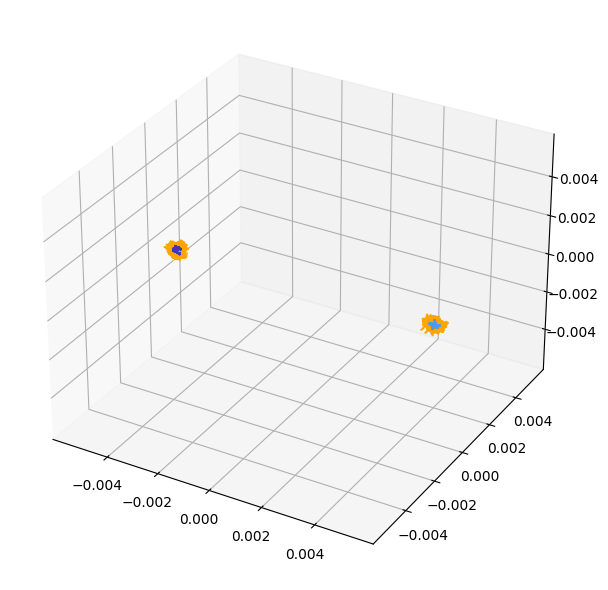

In [7]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=True, plot_dendrite=False, plot_synapses=False)
pn.close() 

__TODO__: Update logic so that if there are no connections allowed between the neurons present in a hyper voxel, 
then it skips those in detection step.

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

Reading SNUDDA_DATA=None from networks/connect_structures_network_projection_detection/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 549/592 (20 neurons)
Processing hyper voxel : 21/592 (20 neurons)
Processing hyper voxel : 565/592 (19 neurons)
Processing hyper voxel : 22/592 (17 neurons)
Processing hyper voxel : 5/592 (17 neurons)
Processing hyper voxel : 545/592 (15 neurons)
Processing hyper voxel : 17/592 (15 neurons)
Processing hyper voxel : 6/592 (13 neurons)
Processing hyper voxel : 25/592 (13 neurons)
Processing hyper voxel : 548/592 (12 neurons)
Processing hyper voxel : 533/592 (12 neurons)
Processing hyper voxel : 550/592 (11 neurons)
Processing hyper voxel : 9/592 (10 neurons)
Processing hyper voxel : 18/592 (10 neurons)
Processing hyper voxel : 561/592 (9 neurons)
Processing hyper voxel : 1/592 (9 neurons)
Processing hyper voxel : 553/592 (8 neurons)
Processing hyper voxel : 566/592 (8 neurons)
Processing hyper voxel :

In [6]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

Read 2591 out of total 2591 synapses


Next we just want to verify that there are indeed projection synapses from dSPN to iSPN in this example. Their axons and dendrites should be out of reach of one another, so any connections found should be the projection synapses we specified in this little test example.

In [7]:
from snudda import SnuddaLoad
sl = SnuddaLoad(network_file=os.path.join(network_path,"network-synapses.hdf5"))

Loading 40 neurons with 1103 synapses and 0 gap junctions


In [8]:
ispn_id = [x["neuronID"] for x in sl.data["neurons"] if x["type"] == "iSPN"]
dspn_id = [x["neuronID"] for x in sl.data["neurons"] if x["type"] == "dSPN"]

If you run in the command line you can use ```load.py``` to list all neurons of a certain type, and also find their pre- and post-synaptic partners. Here we do it using python. We use ```find_synapses``` to extract a subset of the synapse matrix. We know that the first column is presynaptic neuron, and second column is postsynaptic neuron.

In [9]:
synapse_mat, synapse_loc = sl.find_synapses(post_id=ispn_id[0])
presyn_id = set(synapse_mat[:,0])

In [10]:
presyn_id.intersection(dspn_id)

{22, 23, 24, 25, 27, 32}

In this example we see that the first iSPN gets input from four dSPN neurons with id 22, 23, 24, 25 and 31.